In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    readHEPDataCsv,
    implementPairDecayLimit,
    implementPairProductionLimit,
    fromHB5Table1,
    read_csv_from_web,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# CMS 13TeV LHC


## `hSM > a a > bb bb` [2403.10341](https://arxiv.org/abs/2403.10341)

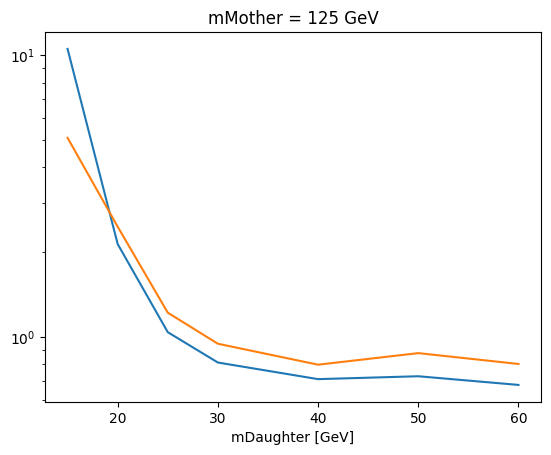

Looks good. Saving this to HV_LHC13_CMS_138.json


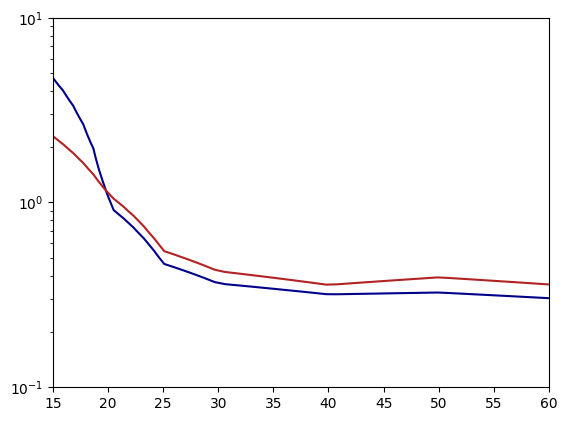

In [3]:
df = pd.DataFrame(
    {
        'mDaughter1': [15, 20, 25, 30, 40, 50, 60],
        'obs':[2.2854638641349885, 1.105578905094436, 0.5475976030421944, 0.4248201698162612, 0.357969606104217, 0.3934339153536932, 0.36008933303543045],
        'exp':[4.724533952482269, 0.9595139254658949, 0.4669074130371089, 0.36436651729009684, 0.31810031748655315, 0.32570206556598064, 0.30342494511212664]
    }
)
df['mMother'] = 125

# prodModes = ["HZ", "HW"]
# ref = HP.SMHiggs(125)
# refCxn = np.sum([ref.cxn("LHC13", p) for p in prodModes])

refCxn = 1.37 + 0.86 # NNLO 
df.obs *= refCxn
df.exp *= refCxn


limitFile = implementPairDecayLimit(
    2769284,
    {
        "production": ['HZ', 'HW'],
        "firstDecay": ["bb"],
        "secondDecay": ["bb"],
    },
    "Fig. 3 (lower)",
    df,
    massResolution={
        "firstDaughter": resolution.bb["medMass"],  # guess
        "secondDaughter": resolution.bb["medMass"],
        "mother": {"absolute": 10, "relative": 0}, #guess
    },
    # constraints={
    #         'firstDaughter':[{'CPValue':'odd'},],
    #         'secondDaughter':[{'CPValue':'odd'},],
    # },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh", "even"))
a = pred.addParticle(HP.NeutralScalar("a", "odd"))
hh.setDecayWidth("a", "a", 1.0)
a.setDecayWidth("bb", 1.0)
hh.setMass(125)
hm = np.linspace(15, 60)
r = np.linspace(1e-1, 10) 

def testAgainstLimit(mass, rate):
    a.setMass(mass)
    rwh = rate * 1.37
    rzh = rate * 0.86
    hh.setCxn("LHC13", "qqHZ", rzh)
    hh.setCxn("LHC13", "HW", rwh)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return app[0].expRatio(), app[0].obsRatio()

test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)

def debug(npda):
    lst = []
    for li in npda:
        lst.append(list(li))
    return(lst)

expR = debug(expR)
obsR = debug(obsR)


fig, ax = plt.subplots(1,1)
expCc = ax.contour(XX, YY, expR, levels=[1.0,], colors=["darkblue"])
obsCc = ax.contour(XX, YY, obsR, levels=[1.0,], colors=["firebrick"])
# expCc.collections[0].set_label("expRatio = 1")
# obsCc.collections[0].set_label("obsRatio = 1")
ax.set_yscale('log')

## `H > hSM hSM > bb bb` [1806.03548](https://arxiv.org/abs/1806.03548)


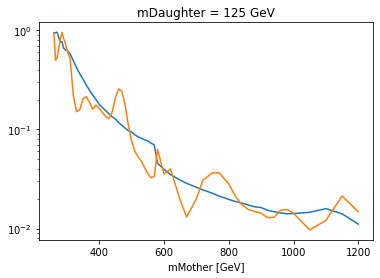

Looks good. Saving this to H_LHC13_CMS_36.json


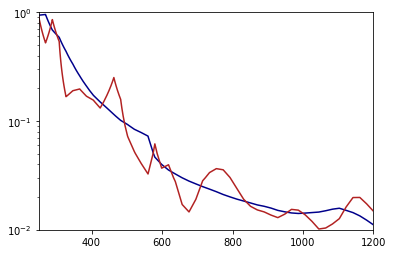

In [2]:
dfExp = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1677276/Table2/1/csv",
    comment="#",
    skiprows=130,
    names=["m", "exp", "unc+", "unc-"],
)

df = read_csv_from_web(
    "https://www.hepdata.net/download/table/ins1677276/Table2/1/csv",
    comment="#",
    skiprows=6,
    skipfooter=192 - 67,
    engine="python",
    names=["mMother", "obs"],
)
assert np.allclose(df.mMother, dfExp.m)
df["exp"] = dfExp.exp
df.exp *= 1e-3  # fb to pb
df.obs *= 1e-3  # fb to pb

df["mDaughter1"] = 125
limitFile = implementPairDecayLimit(
    "1806.03548",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["bb"],
    },
    "https://doi.org/10.17182/hepdata.86134.v1/t2",
    df,
    massResolution={
        "firstDaughter": {"absolute": 40, "relative": 0},  # p 3
        "secondDaughter": {"absolute": 40, "relative": 0},
        "mother": resolution.bb["highMass"],
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setDecayWidth("bb", 1)
h1.setMass(125)
hm = np.linspace(250, 1200)
r = np.linspace(1e-2, 1)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")


## `H > hSM hSM > bbbb` [1808.01473](https://arxiv.org/abs/1808.01473)
Using radion limit

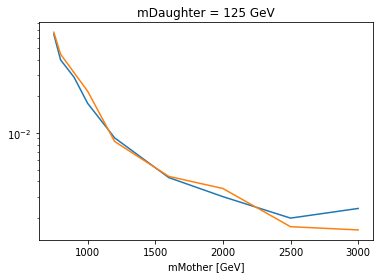

Looks good. Saving this to H_highM_LHC13_CMS_36.json


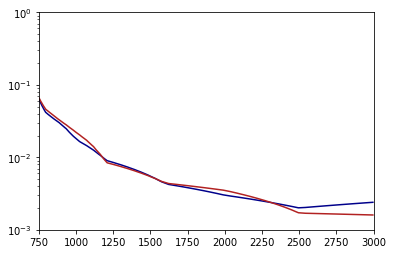

In [6]:
df = pd.DataFrame(
    {
        "mMother": [750, 800, 900, 1000, 1200, 1600, 2000, 2500, 3000],
        "obs": np.array([67.0, 44.3, 31.2, 22.0, 8.5, 4.4, 3.5, 1.7, 1.6]) * 1e-3,
        "exp": np.array([64.5, 39.8, 28.6, 17.5, 9.1, 4.3, 3.0, 2.0, 2.4]) * 1e-3,
    }
)

df["mDaughter1"] = 125

limitFile = implementPairDecayLimit(
    "1808.01473",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["bb"],
    },
    "Tab. 5",
    df,
    massResolution={
        "firstDaughter": {"absolute": 30, "relative": 0},  # 90-140 signal region
        "secondDaughter": {"absolute": 30, "relative": 0},  # 90-140 signal region
        "mother": resolution.bb["highMass"],
    },
    prefix="H_highM",
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
hm = np.linspace(750, 3000)
r = np.logspace(-3, 0)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC13", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()


## `pp > h125 h125 > bbbb` [1810.11854](https://arxiv.org/abs/1810.11854)

In [10]:
df = pd.DataFrame({"m": [125], "obs": 847e-3, "exp": 419e-3})
limitFile = implementPairProductionLimit(
    "1810.11854",
    {"firstDecay": ["bb"], "secondDecay": ["bb"]},
    "Tab. 5",
    df,
    massResolution={  # guess +-20
        "firstParticle": {"absolute": 40, "relative": 0.0},
        "secondParticle": {"absolute": 40, "relative": 0.0},
    },
)

lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
hh.setCxn("LHC13", "pair", 1.0)
hh.setDecayWidth("bb", 1.0)
hh.setMass(125)
res = lim.apply(pred)
print(res)
assert np.isclose(res[0].obsRatio(), 1.0 / df.obs[0])
assert np.isclose(res[0].expRatio(), 1.0 / df.exp[0])


Looks good. Saving this to nonres_LHC13_CMS_36.json
[<Higgs.bounds.AppliedLimit limitId: 181011854, obsRatio: 1.181, expRatio: 2.387, for: ["hh", "+", "hh"]>]


# CMS 8TeV LHC

## `H > hSM hSM > bbbb` [1503.04114](https://arxiv.org/abs/1503.04114)


Looks good. Saving this to H_LHC8_CMS_18.json


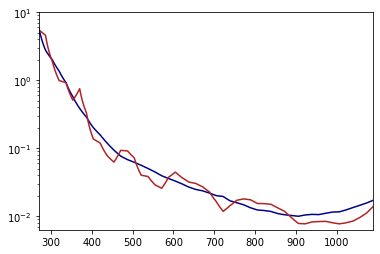

In [4]:
df = fromHB5Table1("14013_H-hh-bbbb_17.9fb-1", "CMS").rename(columns={"m": "mMother"})
df["mDaughter1"] = 125
df.obs /= 1e3  # fb to pb
df.exp /= 1e3
limitFile = implementPairDecayLimit(
    "1503.04114",
    {
        "production": ["H"],
        "firstDecay": ["bb"],
        "secondDecay": ["bb"],
    },
    "Fig. 5 (left)",
    df,
    massResolution={
        "firstDaughter": {"absolute": 2 * 17.5, "relative": 0},  # Fig 1
        "secondDaughter": {"absolute": 2 * 17.5, "relative": 0},
        "mother": resolution.bb["highMass"],
    },
)
lim = HB.Limit(limitFile)

pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setDecayWidth("bb", 1.0)
h1.setMass(125)
hm = np.linspace(270, 1090)
r = np.logspace(-2.2, 1)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
ax.set_yscale("log")
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
plt.show()
